In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import data, io, color
import glob

from skimage.exposure import equalize_hist
from scipy.interpolate import interp1d
from skimage.draw import disk

In [3]:
filenames1 = glob.glob('StaffNov21/resin_d1250_detv-20-*.tif')
filenames2 = glob.glob('StaffNov21/resin_d1250_detv0-*.tif')
filenames3 = glob.glob('StaffNov21/resin_d1250_detv20-*.tif')

def read_files(filenames):
    data = []
    for i in range(0, len(filenames)):
        data.append(np.ndarray.flatten(io.imread(filenames[i])))
        #data.append(io.imread(filenames[i]))
    data = np.asarray(data).T
    
    return data
# Reshape flattened image array to square array
def reshape_image(image):
    x, y = int(len(image)**0.5), int(len(image)**0.5)
    return np.reshape(image, (x, y))

# Import data at each position
data1 = read_files(filenames1)
data2 = read_files(filenames2)
data3 = read_files(filenames3)

# Remove negative values
data1[data1<0] = 0
data2[data2<0] = 0
data3[data3<0] = 0

# Average all images taken at each position
a1 = np.sum(data1, axis = 1)/data1.shape[1]
a2 = np.sum(data2, axis = 1)/data2.shape[1]
a3 = np.sum(data3, axis = 1)/data2.shape[1]
# Reshape flattened average images
a1 = reshape_image(a1)
a2 = reshape_image(a2)
a3 = reshape_image(a3)

# Clear data arrays
del data1; del data2; del data3

# # Function to get dead pixel mask
# # 1 where detector value is 0 or below
# def d_mask(im):
#     dmask = np.copy(im)
#     dmask[dmask>0] = 1
#     dmask[dmask <= 0] = 0
#     dmask = 1-dmask
#     return dmask
# # Fix dead pixels on some input detector image
# def d_pixel(im):
#     dmask = d_mask(im)
#     dim = im*(1-dmask) # Image with masked off dead pixels
#     return inpaint.inpaint_biharmonic(dim, dmask)

# # Reconstruct dead pixels by biharmonic equation inpainting
# #dr1, dr2, dr3 = a1*(1-d_mask(a1)), a2*(1-d_mask(a2)), a3*(1-d_mask(a3))
# #r1, r2, r3 = inpaint.inpaint_biharmonic(dr1, d_mask(a1)), inpaint.inpaint_biharmonic(dr2, d_mask(a2)), inpaint.inpaint_biharmonic(dr3, d_mask(a3))
# r1, r2, r3 = d_pixel(a1), d_pixel(a2), d_pixel(a3)

# Import 2-theta maps
t1 = np.load('StaffNov21/Calibration/2theta map, v-20.npy')
t2 = np.load('StaffNov21/Calibration/2theta map, v0.npy')
t3 = np.load('StaffNov21/Calibration/2theta map, v20.npy')

In [4]:
# Bin 2-theta map
# Input (2-theta map, total number of bins)
# Return bin, map of bin index
def bin_map(tmap, nbins):
    bins = np.linspace(np.min(tmap), np.max(tmap), num = nbins)
    binned = np.digitize(tmap, bins) -1 # Digitize index starts at 1
    return bins, binned

# Unwrap diffraction image
# Takes input of diffraction pattern, 2-theta map, and number of bins
# Defaults to 800 bins if no input is provided
# Return bins and unwrapped radial array
def unwrap_image(data, datamap, bins = 800):
    bins, binmap = bin_map(datamap, bins) # Bin input 2-theta map (bins, map of bins)
    values = np.array((binmap.ravel(), data.ravel())) # Values from diffraction pattern (bin, values)
    rind = np.unique(values[0]) # Unique indicies 
    
    avals = [] # Empty array 
    lengths = np.zeros(len(rind)) # Total count of values at each 2-theta
    for i in range (0, len(rind)):
        pos = np.where(values[0] == rind[i])
        vals = np.ndarray.flatten(values[:, pos][1])
        lengths[i] = len(vals)
        avals.append(vals)
   
    radial_array = np.zeros((len(avals), int(np.max(lengths)))) # Output array for unwrapped values
    for i in range (0, len(avals)):
        nan_array = np.empty( int( np.max(lengths) - len(avals[i]) ) ) # Initialize empty array for values not in measurement
        nan_array[:] = np.nan # Set all values in array to NaN
        radial_array[i] = np.concatenate( (avals[i], nan_array) )
    # Return 2-theta bins and unwrapped array
    return bins, radial_array

# Bootstrap resample unwrapped radial array along horizontal
# Returned array has same number of samples along horizontal
# Subsamples are 10 for no particular reason
def bootstrap_resample(rad_array):
    out_arr = np.empty(rad_array.shape) # Initialize output array
    for i in range (rad_array.shape[0]): # Loop over horizontal rows
        data = np.copy(rad_array[i]) # Copy current row
        data = data[~np.isnan(data)] # Remove nans
        resamples = np.random.choice(data, size = (10, rad_array.shape[1]), replace = True) # 10 x [input horizontal] random samples with replacement 
        medians = np.median(resamples, axis = 0) # Take median across axis 0 to return [input horizontal] medians
        out_arr[i] = medians # Put medians in output array
    return out_arr

# Interpolate the bootstrapped data map and return interpolating function
# Pick range of 2-theta values at high 2-theta to use for extrapolation at high 2-theta
# Pass bootstrapped map, bins from unwrapping function ( unwrap_image() ), min 2theta, and max 2theta
# Extrapolate to twice the input 2-theta value
def interpolate_bstrap(bmap, bins, min_val, max_val):
    median_vals = np.median(bmap, axis = 1) # Take median of bootstrapped array
    f = interp1d(bins, median_vals, kind = 'slinear', fill_value = 'extrapolate') # Interpolate data using order 1 splines
    x_extrap = np.linspace(min_val, max_val, 100) # Get x-values for extrapolation at high 2-theta
    y_extrap = f(x_extrap) # Get y-values for extrapolation from previous interpolation
    f_extrap = interp1d(x_extrap, y_extrap, kind = 'slinear', fill_value = 'extrapolate') # Function for extrapolating high 2-theta using order 1 splines
    
    # Calculate new values including extrapolated region
    # Use 5000 points for interpolation for no particular reason
    x_new = np.linspace(bins[0], bins[-1]*2, 5000) # X values
    y_new = [] # Array for y values
    for i in range (0, len(x_new)):
        if x_new[i] <= min_val:
            y_new.append(f(x_new[i])) # Below cutoff use intepolation of data
        if x_new[i] > min_val:
            y_new.append(f_extrap(x_new[i])) # Above cutoff use extrapolation from cutoff range specified
    y_new = np.array(y_new)
    # Calculate interpolating function for new y-values that include extrapolation at high 2-theta
    # Use order 1 splines for interpolation
    f_out = interp1d(x_new,y_new, kind = 'slinear', fill_value = 'extrapolate')
    return f_out

# Calculate a gain map from three positions
# Input set of average images at three positions (pos1, pos2, pos3) and corresponding 2-theta maps (tmap1, tmap2, tmap3)
# Provide min/max for 2-theta region to use for extrapolation for high 2-theta (e_min, e_max). This provides an estimated gain at high 2-theta
# Select position (1, 2, 3) to return gain map for, returns gain map for position 1 by default
# Gain map at edges where information is estimated by extrapolation is probably not super reliable
# Gain map inside beamstop is also not correct
def gain_map(pos1, pos2, pos3, tmap1, tmap2, tmap3, e_min, e_max, position = 1):
    # Unwrap images to generate maps of 2-theta vs number of counts
    bins1, map1 = unwrap_image(pos1, tmap1)
    bins2, map2 = unwrap_image(pos2, tmap2)
    bins3, map3 = unwrap_image(pos3, tmap3)
    # Bootstrap resample unwrapped maps
    # Improvement appears marginal, not clear if this actually necessary but it adds only ~5s per position
    bmap1 = bootstrap_resample(map1)
    bmap2 = bootstrap_resample(map2)
    bmap3 = bootstrap_resample(map3)
    # Interpolate bootstrapped maps 
    ifun1 = interpolate_bstrap(bmap1, bins1, e_min, e_max)
    ifun2 = interpolate_bstrap(bmap2, bins2, e_min, e_max)
    ifun3 = interpolate_bstrap(bmap3, bins3, e_min, e_max)
    
    #test = (ifun1(tmap1)+ifun2(tmap1)+ifun3(tmap1))/3
    #gmap = a1/test
    if position == 1:
        signal = (ifun1(tmap1)+ifun2(tmap1)+ifun3(tmap1))/3 # Generate 3 estimated signals at position and then average
        gmap = pos1/signal
    if position == 2:
        signal = (ifun1(tmap2)+ifun2(tmap2)+ifun3(tmap2))/3 # Generate 3 estimated signals at position and then average
        gmap = pos2/signal
    if position == 3:
        signal = (ifun1(tmap3)+ifun2(tmap3)+ifun3(tmap3))/3 # Generate 3 estimated signals at position and then average
        gmap = pos3/signal
    
    return gmap # Return gainmap

In [4]:
import time
start = time.time()
test_map1 = gain_map(a1, a2, a3, t1, t2, t3, 12, 13, 1)
test_map2 = gain_map(a1, a2, a3, t1, t2, t3, 12, 13, 2)
test_map3 = gain_map(a1, a2, a3, t1, t2, t3, 12, 13, 3)
stop = time.time()
print (stop-start)

146.41480207443237


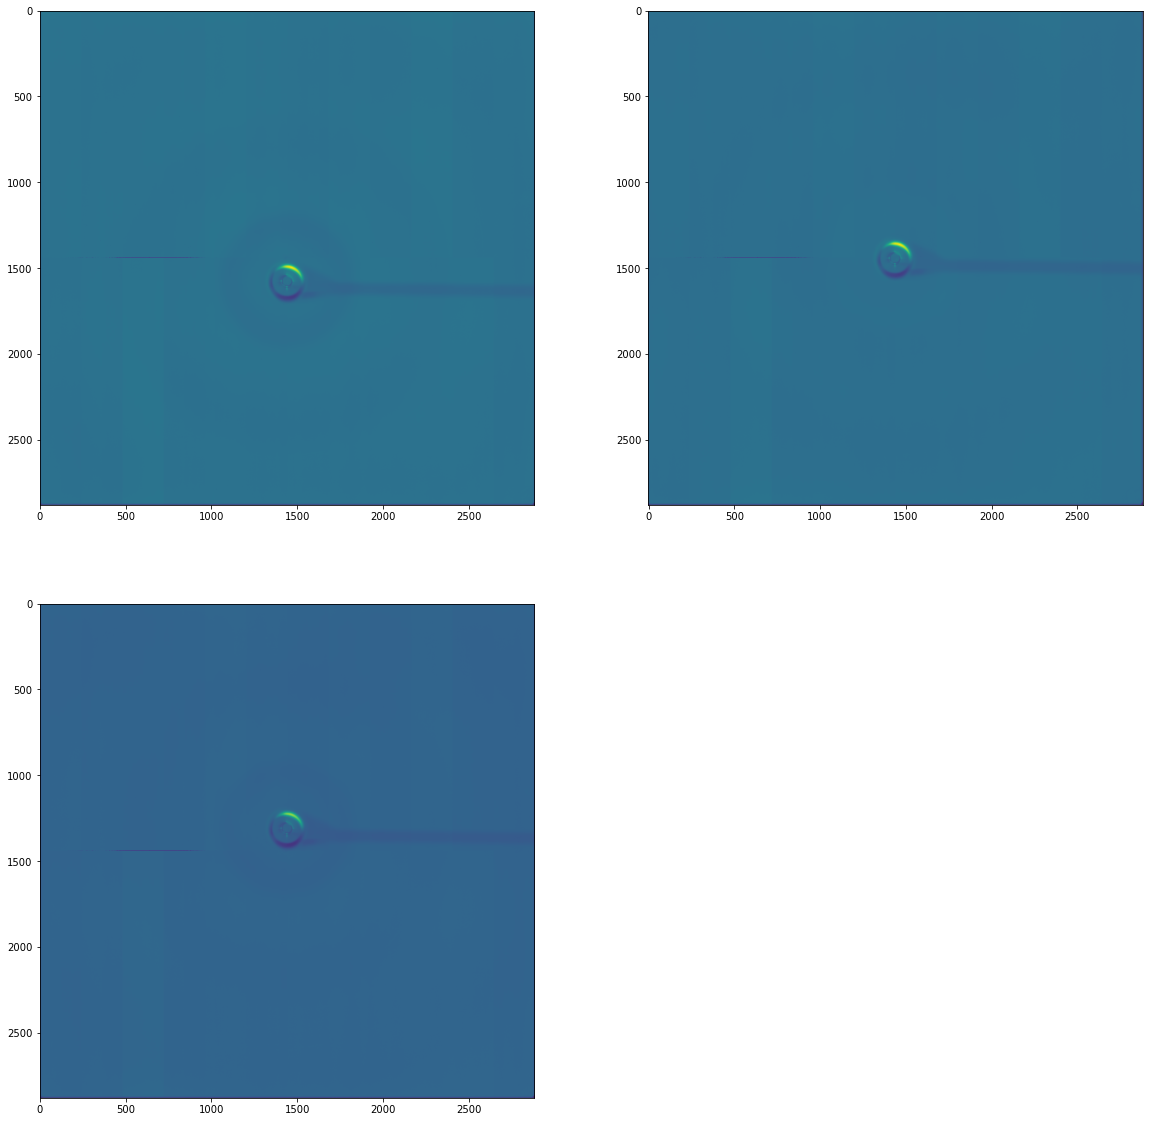

In [5]:
plt.rcParams["figure.figsize"] = (20,20)
plt.subplot(2, 2, 1)
plt.imshow(test_map1)
plt.subplot(2, 2, 2)
plt.imshow(test_map2)
plt.subplot(2, 2, 3)
plt.imshow(test_map3)

In [6]:
# Load a measurement at each position
im1 = io.imread(filenames1[0])
im2 = io.imread(filenames2[0])
im3 = io.imread(filenames3[0])
# Set values below 0 to 0
im1[im1<0] = 0
im2[im2<0] = 0
im3[im3<0] = 0

Text(0.5, 1.0, 'Position 3 measurement')

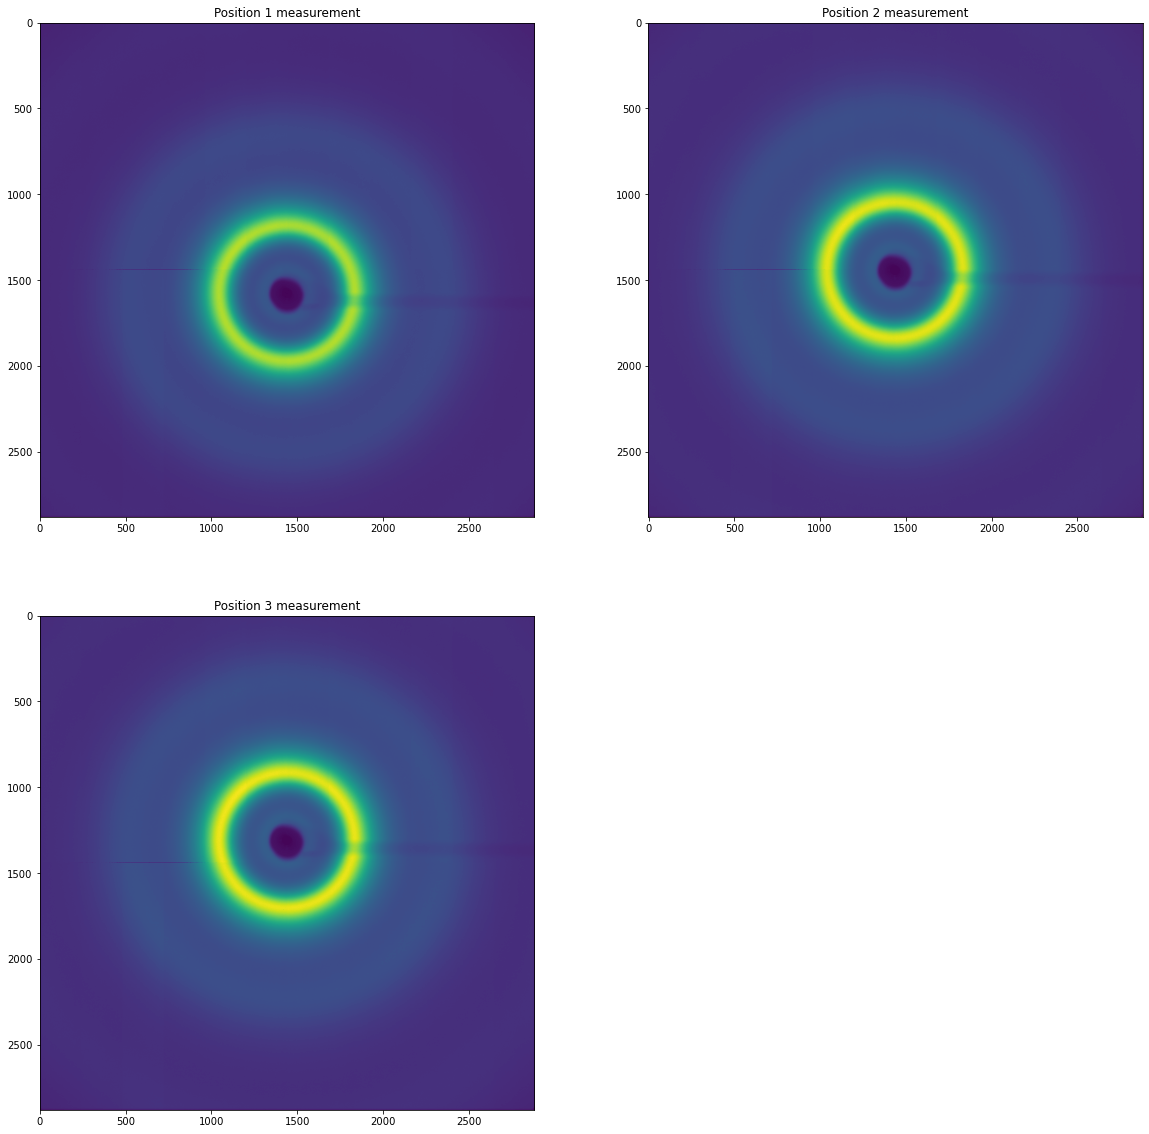

In [7]:
plt.rcParams["figure.figsize"] = (20,20)
plt.subplot(2, 2, 1)
plt.imshow(im1)
plt.title('Position 1 measurement')
plt.subplot(2, 2, 2)
plt.imshow(im2)
plt.title('Position 2 measurement')
plt.subplot(2, 2, 3)
plt.imshow(im3)
plt.title('Position 3 measurement')

C:\Users\jmswe\AppData\Local\Temp/ipykernel_4708/1643229067.py:1: RuntimeWarning: invalid value encountered in true_divide
  c1 = np.nan_to_num(im1/test_map1)
C:\Users\jmswe\AppData\Local\Temp/ipykernel_4708/1643229067.py:2: RuntimeWarning: invalid value encountered in true_divide
  c2 = np.nan_to_num(im2/test_map2)
C:\Users\jmswe\AppData\Local\Temp/ipykernel_4708/1643229067.py:3: RuntimeWarning: invalid value encountered in true_divide
  c3 = np.nan_to_num(im3/test_map3)


Text(0.5, 1.0, 'Position 3 gain corrected')

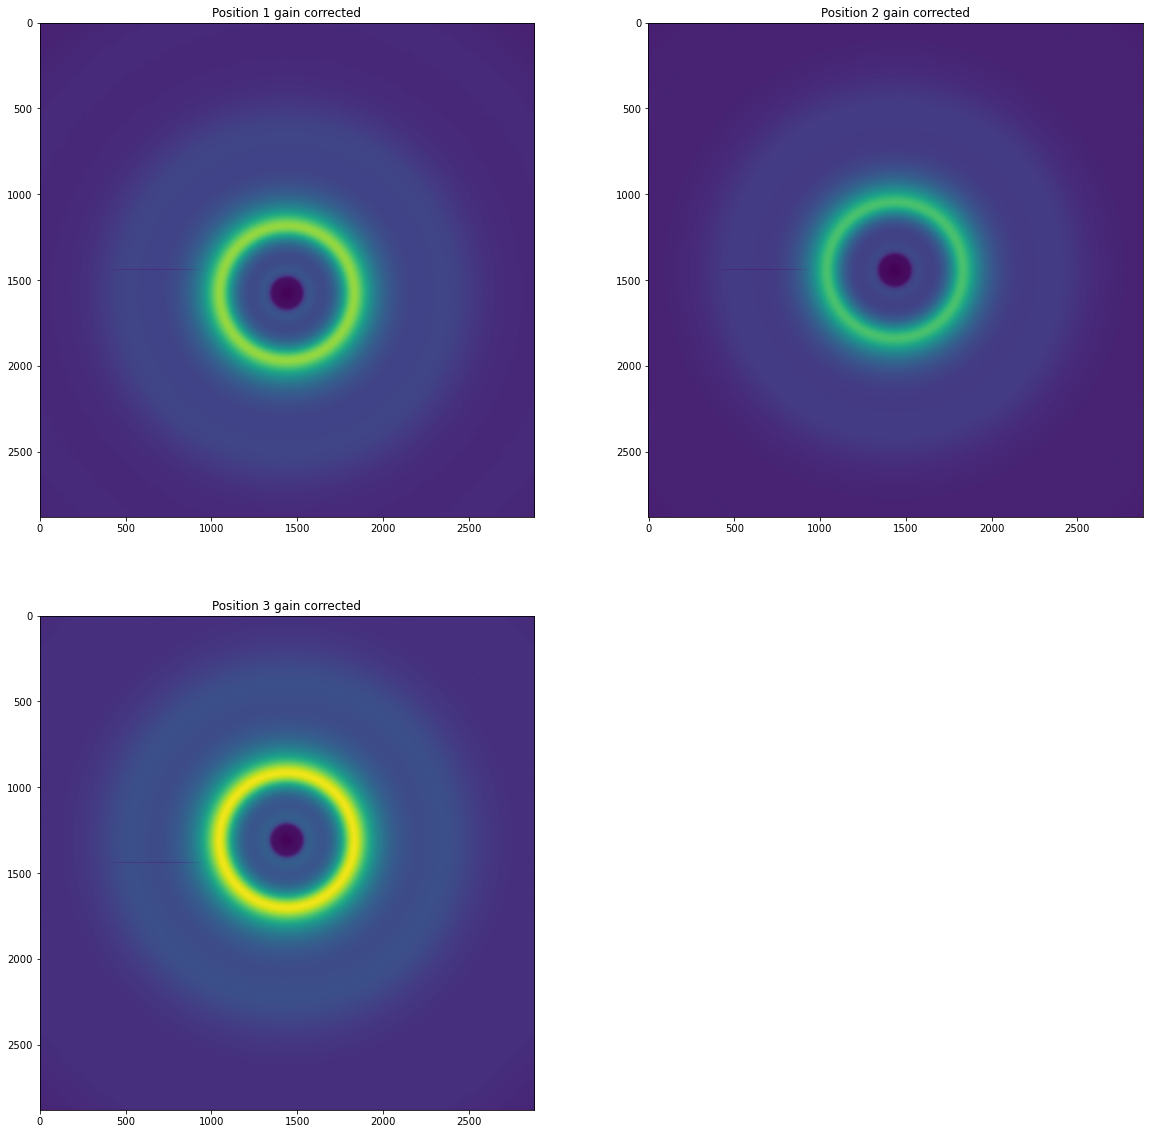

In [8]:
c1 = np.nan_to_num(im1/test_map1)
c2 = np.nan_to_num(im2/test_map2)
c3 = np.nan_to_num(im3/test_map3)

plt.rcParams["figure.figsize"] = (20,20)
plt.subplot(2, 2, 1)
plt.imshow(c1)
plt.title('Position 1 gain corrected')
plt.subplot(2, 2, 2)
plt.imshow(c2)
plt.title('Position 2 gain corrected')
plt.subplot(2, 2, 3)
plt.imshow(c3)
plt.title('Position 3 gain corrected')

Text(0.5, 1.0, 'Position 3 contrast adjusted')

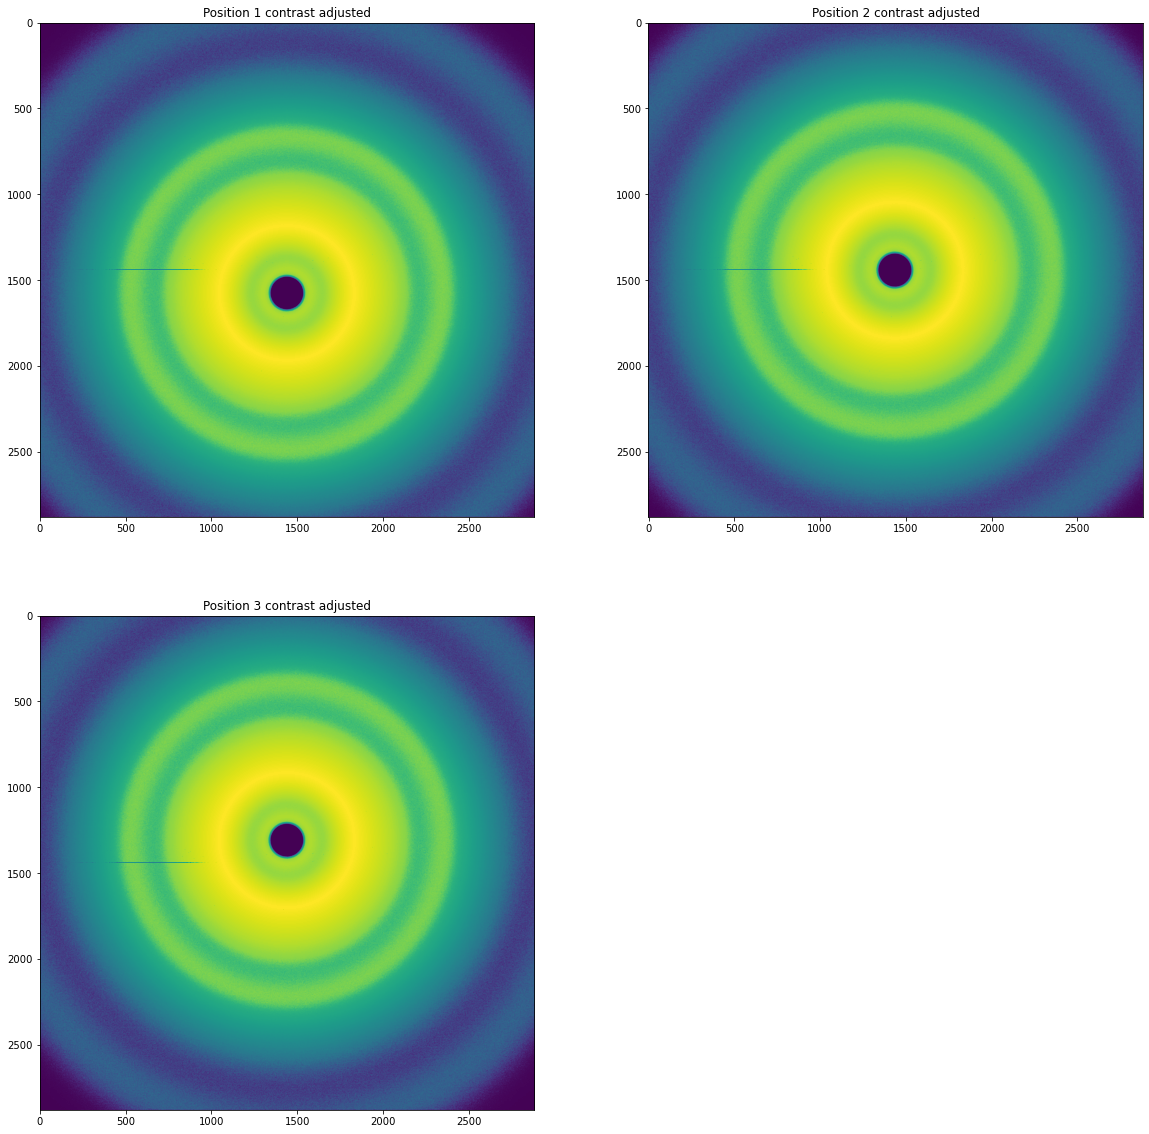

In [9]:
ca1 = equalize_hist(c1)
ca2 = equalize_hist(c2)
ca3 = equalize_hist(c3)

plt.rcParams["figure.figsize"] = (20,20)
plt.subplot(2, 2, 1)
plt.imshow(ca1)
plt.title('Position 1 contrast adjusted')
plt.subplot(2, 2, 2)
plt.imshow(ca2)
plt.title('Position 2 contrast adjusted')
plt.subplot(2, 2, 3)
plt.imshow(ca3)
plt.title('Position 3 contrast adjusted')

In [6]:
test_map2 = gain_map(a1, a2, a3, t1, t2, t3, 12, 13, 2)

In [5]:
from skimage import io

In [6]:
io.imsave('Gain map, pos 2.tif', test_map2)

In [7]:
filenames2 = glob.glob('StaffNov21/resin_d1250_detv0-*.tif')

In [9]:
test = io.imread(filenames2[0])

In [10]:
test.dtype

dtype('float32')

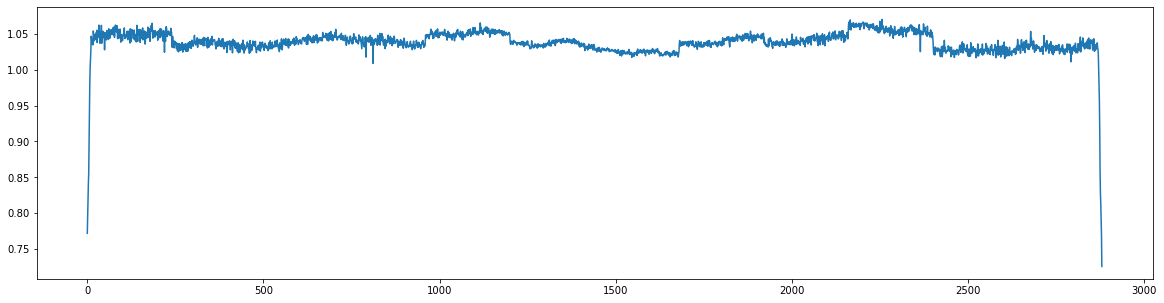

In [7]:
plt.rcParams["figure.figsize"] = (20,5) 
plt.plot(test_map2[1000])

In [18]:
np.save('Gain map, pos2.npy', test_map2)